# Team, Skoltech project for implementing async method of optimization in neural networks:
Denis Boborukhin,
Dmitriy Kosenkov,
Alexander Marukhin,

Вот пример работы `Executor.submit`, который позволяет бить на пулы выполнение задачи.
Подробнее о concurrent.futures: [Хабр о конкуррентах и фьючерсах](https://habr.com/ru/companies/otus/articles/771346/)

Главное, что нам дает:


1.   Выполняется параллельно и не надо париться насчет питонячьего GIL
2.   Может выполняться также и асинхронно на более серьезных задачах
3.   `submit` метод ниже работает вот так: мы ему дали задачи, он нам выдал взамен future. выполнение `future.result()` происходит только тогда, когда задача на данном потоке выполнена.



In [1]:
%%time
from time import sleep

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

slowadd(1,1)

CPU times: user 819 µs, sys: 853 µs, total: 1.67 ms
Wall time: 1e+03 ms


2

In [2]:
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(1) as e:
    future = e.submit(slowadd, 1, 2)
    print(future.result())


3


Ниже код для **Rennala**:

In [3]:
import numpy as np

Заготовки для нашего будущего функционала, градиентов:

In [4]:
def f_i(w, i):
    """Loss for sample i:."""
    pass

def grad_f_i(w, i):
    """Gradient of f_i with respect to w."""
    pass

def f_full(w):
    """Full objective: average of f_i."""
    pass

def grad_f_full(w):
    """Full gradient: average of gradients."""
    pass

In [5]:
def step_sgd(w_pred, batch_size):
    i = np.random.randint(0, n)
    grad= grad_f_i(w, i)
    w = w-(1/batch_size) * grad
    return w



In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Plot settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported.")


Libraries imported.


In [7]:
# Generate a synthetic finite-sum least squares regression dataset
n = 2000   # number of samples
d = 20     # dimension
noise_std = 0.1

# True parameter
w_true = np.random.randn(d)

# Features
X = np.random.randn(n, d)

# Targets with Gaussian noise
y = X @ w_true + noise_std * np.random.randn(n)

print("Data shape X:", X.shape, "y:", y.shape)

# Define individual loss and its gradient
def f_i(w, i):
    """Loss for sample i: 0.5 * (y_i - x_i^T w)^2."""
    r = y[i] - X[i] @ w
    return 0.5 * r**2

def grad_f_i(w, i):
    """Gradient of f_i with respect to w."""
    r = y[i] - X[i] @ w
    return -r * X[i]

def f_full(w):
    """Full objective: average of f_i."""
    residuals = y - X @ w
    return 0.5 * np.mean(residuals**2)

def grad_f_full(w):
    """Full gradient: average of gradients."""
    residuals = y - X @ w
    return -(X.T @ residuals) / n


Data shape X: (2000, 20) y: (2000,)


/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3283210991.py:13: RuntimeWarning: divide by zero encountered in matmul
  y = X @ w_true + noise_std * np.random.randn(n)
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3283210991.py:13: RuntimeWarning: overflow encountered in matmul
  y = X @ w_true + noise_std * np.random.randn(n)
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3283210991.py:13: RuntimeWarning: invalid value encountered in matmul
  y = X @ w_true + noise_std * np.random.randn(n)


In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def rennala(x0, gamma=0.01, S=32, K=100, workers=4):
    x = x0.copy()
    hist, losses = [x.copy()],[]

    with ThreadPoolExecutor(workers) as ex:
        for k in range(K):
            futures, g, s = [], np.zeros_like(x), 0

            for _ in range(min(S,workers)):
                futures.append(ex.submit(grad_f_i, x, np.random.randint(n)))

            for f in as_completed(futures):
                g += f.result() / S
                s += 1
                if s < S:
                    futures.append(ex.submit(grad_f_i, x, np.random.randint(n)))
                if s >= S:
                    for f_ in futures: f_.cancel()
                    break

            x = x - gamma *g
            hist.append(x.copy())
            losses.append(0.5 * np.mean((y - X @ x)**2))

    return x, hist, losses


duration is:0.019036750000000158


/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/834997453.py:25: RuntimeWarning: divide by zero encountered in matmul
  losses.append(0.5 * np.mean((y - X @ x)**2))
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/834997453.py:25: RuntimeWarning: overflow encountered in matmul
  losses.append(0.5 * np.mean((y - X @ x)**2))
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/834997453.py:25: RuntimeWarning: invalid value encountered in matmul
  losses.append(0.5 * np.mean((y - X @ x)**2))


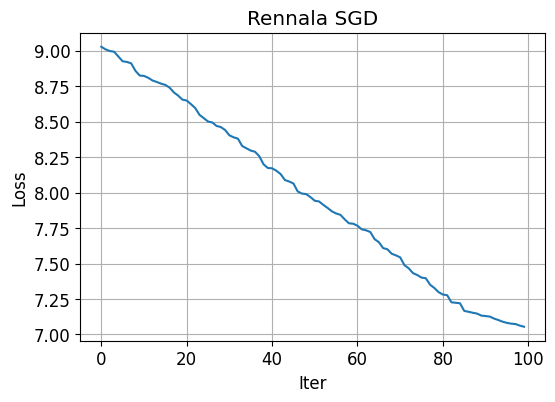

In [9]:
import time

x0 = np.zeros(d)

start = time.perf_counter()
w, hist, losses = rennala(x0)
end = time.perf_counter()
duration = end - start

print(f'duration is:{duration}')

plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.xlabel('Iter'); plt.ylabel('Loss')
plt.title('Rennala SGD'); plt.grid(True)
plt.show()

In [10]:
def L_num(X, y, num_samples=1000):
    max_ratio = 0
    n_samples = X.shape[0]

    for _ in range(num_samples):
        w1 = np.random.randn(d)
        w2 = np.random.randn(d) + 1e-6  # a lil noise
        # precomp grads
        grad1 = X.T @ (X @ w1 - y) / n
        grad2 = X.T @ (X @ w2 - y) / n
        grad_d= np.linalg.norm(grad1 - grad2)
        w_d = np.linalg.norm(w1 - w2)

        if w_d > 1e-10:
            ratio = grad_d/w_d
            max_ratio = max(max_ratio, ratio)

    return max_ratio

L_number = L_num(X, y, num_samples=500)


/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3031579401.py:9: RuntimeWarning: divide by zero encountered in matmul
  grad1 = X.T @ (X @ w1 - y) / n
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3031579401.py:9: RuntimeWarning: overflow encountered in matmul
  grad1 = X.T @ (X @ w1 - y) / n
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3031579401.py:9: RuntimeWarning: invalid value encountered in matmul
  grad1 = X.T @ (X @ w1 - y) / n
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3031579401.py:10: RuntimeWarning: divide by zero encountered in matmul
  grad2 = X.T @ (X @ w2 - y) / n
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3031579401.py:10: RuntimeWarning: overflow encountered in matmul
  grad2 = X.T @ (X @ w2 - y) / n
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3031579401.py:10: RuntimeWarning: invalid value encountered in matmul
  grad2 = X.T @ (X @ w2 - y) / n


duration is:0.005681291999999782


/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/834997453.py:25: RuntimeWarning: divide by zero encountered in matmul
  losses.append(0.5 * np.mean((y - X @ x)**2))
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/834997453.py:25: RuntimeWarning: overflow encountered in matmul
  losses.append(0.5 * np.mean((y - X @ x)**2))
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/834997453.py:25: RuntimeWarning: invalid value encountered in matmul
  losses.append(0.5 * np.mean((y - X @ x)**2))


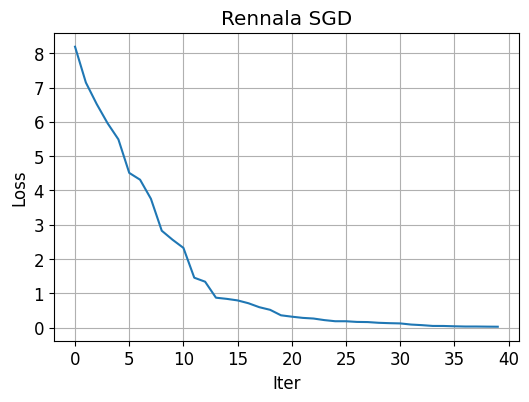

In [11]:
import time

x0 = np.zeros(d)

start = time.perf_counter()
w, hist, losses = rennala(x0, 1/L_number, K = 40)
end = time.perf_counter()
duration = end - start

print(f'duration is:{duration}')

plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.xlabel('Iter'); plt.ylabel('Loss')
plt.title('Rennala SGD'); plt.grid(True)
plt.show()

Тест с обычным SGD:

In [12]:
def run_sgd(w0, steps, eta):
    w = w0.copy()
    obj_values = []
    grad_evals = []
    num_grad_evals = 0

    for t in range(steps):
        i = np.random.randint(0, n)
        grad= grad_f_i(w, i)
        w = w-eta * grad
        num_grad_evals += 1
        grad_evals.append(num_grad_evals)
        obj_values.append(f_full(w))

        if t % 1000 == 0:
            print(f"Step {t}, Objective: {obj_values[-1]}")
    return np.array(grad_evals), np.array(obj_values)

In [13]:
# Run experiments
w0 = np.zeros(d)

# Hyperparameters (chosen to give reasonable but not perfect tuning)
steps = 8000
eta_sgd = 0.02
eta_mom = 0.02
eta_mom_svrg = 0.01
beta = 0.9

# For SVRG: number of epochs and inner steps m
epochs = 20
m = 200  # total inner steps = epochs * m

print("Initial objective:", f_full(w0))

# SGD
start = time.perf_counter()
ge_sgd, obj_sgd = run_sgd(w0, steps=steps, eta=eta_sgd)
end = time.perf_counter()
duration = end - start
print(f'sgd duration {duration}')

print("Final objectives:")
print("  SGD:            ", obj_sgd[-1])



Initial objective: 9.043956519868624
Step 0, Objective: 9.039601654459373
Step 1000, Objective: 0.006216692337536765
Step 2000, Objective: 0.0065247404454662735


/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3283210991.py:30: RuntimeWarning: divide by zero encountered in matmul
  residuals = y - X @ w
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3283210991.py:30: RuntimeWarning: overflow encountered in matmul
  residuals = y - X @ w
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_39354/3283210991.py:30: RuntimeWarning: invalid value encountered in matmul
  residuals = y - X @ w


Step 3000, Objective: 0.0056538693435290634
Step 4000, Objective: 0.00709095933482784
Step 5000, Objective: 0.006380873711545385
Step 6000, Objective: 0.006171686155020398
Step 7000, Objective: 0.00574290894008551
sgd duration 0.1114761660000001
Final objectives:
  SGD:             0.005727451809422467
